In [1]:
# Skip this cell if we are not on Google Colab
try:
    # Mount Google Drive to the Colab VM.
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

    # Specify working directory.
    FOLDERNAME = 'cs231n/project/'
    %cd /content/drive/My\ Drive/$FOLDERNAME

    # Ensure that the Python interpreter of the Colab VM can load python files from
    # within it.
    import sys
    sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
except ImportError as e:
    print("Not on Google Colab.")

Not on Google Colab.


## Load dataset and labels

In [2]:
# check RAM usage
import os
tot_m, used_m, free_m = map(int, os.popen('free -t -g').readlines()[-1].split()[1:])
tot_m, used_m, free_m

(59, 0, 46)

In [3]:
!ls /home/ubuntu

LICENSE			       test_data_pre60.npy
Nvidia_Cloud_EULA.pdf	       tools
README			       train_actions_pre12.npy
anaconda3		       train_actions_pre60.npy
cs231n-project		       train_data_pre60.npy
download_dataset_to_aws.ipynb  train_data_pre60.npy.zip
examples		       tutorials
src			       val_actions_pre12.npy
test_actions_pre12.npy	       val_actions_pre60.npy
test_actions_pre60.npy	       val_data_pre60.npy


In [4]:
import numpy as np
import os

#base_dir = '/content/drive/My Drive/cs231n/project/dataset/shaped_hrnet_data'
base_dir = '/home/ubuntu'

train_data = np.load(os.path.join(base_dir, 'train_data_pre60.npy'))
train_actions = np.load(os.path.join(base_dir, 'train_actions_pre60.npy'), allow_pickle=True)

val_data = np.load(os.path.join(base_dir, 'val_data_pre60.npy'))
val_actions = np.load(os.path.join(base_dir, 'val_actions_pre60.npy'), allow_pickle=True)

In [5]:
# reshape data
train_data = np.moveaxis(train_data, 2, -1)
val_data = np.moveaxis(val_data, 2, -1)

In [6]:
print('Training data shape: ', train_data.shape)
print('Training action shape: ', train_actions.shape)
print('Validation data shape: ', val_data.shape)
print('Validation action shape: ', val_actions.shape)

Training data shape:  (1007, 60, 64, 48, 17)
Training action shape:  (1007,)
Validation data shape:  (433, 60, 64, 48, 17)
Validation action shape:  (433,)


In [7]:
mapping = {
    'CALL': 0,
    'COUG': 1,
    'DRIN': 2,
    'SCRA': 3,
    'SNEE': 4,
    'STRE': 5,
    'WAVE': 6,
    'WIPE': 7,
}
train_action_labels = [mapping[x] for x in train_actions]
val_action_labels = [mapping[x] for x in val_actions]

# One-hot encoding.
train_action_labels = np.eye(8)[train_action_labels] 
val_action_labels = np.eye(8)[val_action_labels] 

<function matplotlib.pyplot.show(close=None, block=None)>

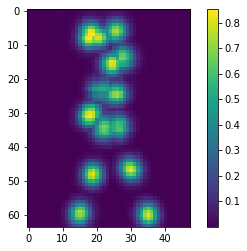

In [8]:
# make sure input dataset is correct
import matplotlib.pyplot as plt

plt.imshow(np.max(train_data[0,-1,:,:,:], axis=-1))
plt.colorbar()
plt.show

In [11]:
print(f"special value may be: {train_data[1,0,:,:,:].max(axis=-1)}")

special value may be: [[-10. -10. -10. ... -10. -10. -10.]
 [-10. -10. -10. ... -10. -10. -10.]
 [-10. -10. -10. ... -10. -10. -10.]
 ...
 [-10. -10. -10. ... -10. -10. -10.]
 [-10. -10. -10. ... -10. -10. -10.]
 [-10. -10. -10. ... -10. -10. -10.]]


In [10]:
train_data.shape

(1007, 60, 64, 48, 17)

## Model Structure: HR-Net + LSTM

In [12]:
from keras.layers import Input, TimeDistributed, Conv2D, Dense, MaxPooling2D, Flatten, LSTM, Dropout, BatchNormalization, Masking
from keras import models

# hr-net heatmap: (x, 60, 64, 48, 17)
timesteps = 60
rows, columns, channels = 64, 48, 17
special_value = -10.0

model = models.Sequential()
model.add(Input(shape=(timesteps, rows, columns, channels)))
model.add(TimeDistributed(Flatten()))
model.add(Dropout(0.2))

model.add(Masking(mask_value=special_value))
model.add(LSTM(16, return_sequences=False, dropout=0.2)) # used 16 units

#model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8, activation='softmax')) # n_labels = 8
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 60, 52224)         0         
_________________________________________________________________
dropout (Dropout)            (None, 60, 52224)         0         
_________________________________________________________________
masking (Masking)            (None, 60, 52224)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 16)                3343424   
_________________________________________________________________
dense (Dense)                (None, 32)                544       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 2

In [13]:
import keras
callbacks_list = [keras.callbacks.EarlyStopping(monitor='accuracy', patience=5),
                  keras.callbacks.ModelCheckpoint(
                      filepath='hrnet_lstm_model_v1',
                      monitor='val_loss',
                      save_best_only=True
                  ),
                  keras.callbacks.ReduceLROnPlateau(
                      monitor="val_loss", factor=0.1, patience=3
                  )]

from keras import optimizers

optimizer_new=optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None,
                              decay=0.0, amsgrad=False)
model.compile(optimizer=optimizer_new,
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [14]:
history = model.fit(train_data, train_action_labels,
                    validation_data=(val_data, val_action_labels),
                    batch_size=10, epochs=50,
                    callbacks=callbacks_list
                    )

Epoch 1/50
101/101 [==============================] - 31s 241ms/step - loss: 2.0596 - accuracy: 0.1761 - val_loss: 1.9779 - val_accuracy: 0.2102


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


Epoch 2/50
101/101 [==============================] - 13s 131ms/step - loss: 1.9273 - accuracy: 0.2796 - val_loss: 1.8697 - val_accuracy: 0.2564


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


Epoch 3/50
101/101 [==============================] - 13s 133ms/step - loss: 1.8096 - accuracy: 0.3263 - val_loss: 1.7796 - val_accuracy: 0.3233


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


Epoch 4/50
101/101 [==============================] - 13s 134ms/step - loss: 1.7021 - accuracy: 0.3956 - val_loss: 1.7726 - val_accuracy: 0.3141


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


Epoch 5/50
101/101 [==============================] - 13s 131ms/step - loss: 1.6462 - accuracy: 0.3978 - val_loss: 1.6504 - val_accuracy: 0.3926


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


Epoch 6/50
101/101 [==============================] - 13s 133ms/step - loss: 1.4902 - accuracy: 0.4961 - val_loss: 1.5971 - val_accuracy: 0.3741


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


Epoch 7/50
101/101 [==============================] - 13s 132ms/step - loss: 1.3941 - accuracy: 0.5745 - val_loss: 1.5864 - val_accuracy: 0.3926


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


Epoch 8/50
101/101 [==============================] - 13s 131ms/step - loss: 1.3526 - accuracy: 0.5726 - val_loss: 1.4924 - val_accuracy: 0.4596


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


Epoch 9/50
101/101 [==============================] - 14s 137ms/step - loss: 1.2784 - accuracy: 0.6156 - val_loss: 1.4243 - val_accuracy: 0.4850


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


Epoch 10/50
101/101 [==============================] - 13s 131ms/step - loss: 1.2253 - accuracy: 0.6336 - val_loss: 1.4244 - val_accuracy: 0.4711
Epoch 11/50
101/101 [==============================] - 13s 131ms/step - loss: 1.1718 - accuracy: 0.6455 - val_loss: 1.3792 - val_accuracy: 0.5035


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


Epoch 12/50
101/101 [==============================] - 14s 135ms/step - loss: 1.1053 - accuracy: 0.6630 - val_loss: 1.2810 - val_accuracy: 0.5450


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


Epoch 13/50
101/101 [==============================] - 13s 132ms/step - loss: 0.9894 - accuracy: 0.7404 - val_loss: 1.2781 - val_accuracy: 0.5450


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


Epoch 14/50
101/101 [==============================] - 13s 132ms/step - loss: 0.9763 - accuracy: 0.7276 - val_loss: 1.2724 - val_accuracy: 0.5612


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


Epoch 15/50
101/101 [==============================] - 13s 133ms/step - loss: 0.9584 - accuracy: 0.7231 - val_loss: 1.2044 - val_accuracy: 0.5381


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


Epoch 16/50
101/101 [==============================] - 13s 133ms/step - loss: 0.8478 - accuracy: 0.7667 - val_loss: 1.1611 - val_accuracy: 0.5820


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


Epoch 17/50
101/101 [==============================] - 13s 132ms/step - loss: 0.8476 - accuracy: 0.7689 - val_loss: 1.1545 - val_accuracy: 0.5797


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


Epoch 18/50
101/101 [==============================] - 13s 131ms/step - loss: 0.8506 - accuracy: 0.7554 - val_loss: 1.1028 - val_accuracy: 0.5889


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


Epoch 19/50
101/101 [==============================] - 13s 133ms/step - loss: 0.7397 - accuracy: 0.8002 - val_loss: 1.0868 - val_accuracy: 0.6028


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


Epoch 20/50
101/101 [==============================] - 13s 132ms/step - loss: 0.7208 - accuracy: 0.7875 - val_loss: 1.0867 - val_accuracy: 0.5982


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


Epoch 21/50
101/101 [==============================] - 13s 132ms/step - loss: 0.7220 - accuracy: 0.8029 - val_loss: 1.0145 - val_accuracy: 0.6166


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


Epoch 22/50
101/101 [==============================] - 13s 133ms/step - loss: 0.6209 - accuracy: 0.8396 - val_loss: 1.0026 - val_accuracy: 0.6282


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


Epoch 23/50
101/101 [==============================] - 13s 132ms/step - loss: 0.6139 - accuracy: 0.8419 - val_loss: 1.0616 - val_accuracy: 0.5820
Epoch 24/50
101/101 [==============================] - 13s 131ms/step - loss: 0.6242 - accuracy: 0.8265 - val_loss: 0.9690 - val_accuracy: 0.6166


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


Epoch 25/50
101/101 [==============================] - 13s 133ms/step - loss: 0.5547 - accuracy: 0.8507 - val_loss: 1.0517 - val_accuracy: 0.5912
Epoch 26/50
101/101 [==============================] - 13s 132ms/step - loss: 0.6537 - accuracy: 0.8209 - val_loss: 1.0766 - val_accuracy: 0.5843
Epoch 27/50
101/101 [==============================] - 13s 132ms/step - loss: 0.5363 - accuracy: 0.8581 - val_loss: 0.9832 - val_accuracy: 0.6259
Epoch 28/50
101/101 [==============================] - 14s 136ms/step - loss: 0.5270 - accuracy: 0.8739 - val_loss: 0.9245 - val_accuracy: 0.6536


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


Epoch 29/50
101/101 [==============================] - 13s 132ms/step - loss: 0.4839 - accuracy: 0.8864 - val_loss: 0.9165 - val_accuracy: 0.6513


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


Epoch 30/50
101/101 [==============================] - 13s 131ms/step - loss: 0.4733 - accuracy: 0.8849 - val_loss: 0.9138 - val_accuracy: 0.6582


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


Epoch 31/50
101/101 [==============================] - 14s 135ms/step - loss: 0.4458 - accuracy: 0.8953 - val_loss: 0.9167 - val_accuracy: 0.6605
Epoch 32/50
101/101 [==============================] - 13s 132ms/step - loss: 0.4678 - accuracy: 0.8745 - val_loss: 0.9156 - val_accuracy: 0.6582
Epoch 33/50
101/101 [==============================] - 13s 133ms/step - loss: 0.4520 - accuracy: 0.8854 - val_loss: 0.9089 - val_accuracy: 0.6605


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


Epoch 34/50
101/101 [==============================] - 14s 134ms/step - loss: 0.4918 - accuracy: 0.8696 - val_loss: 0.9215 - val_accuracy: 0.6467
Epoch 35/50
101/101 [==============================] - 13s 131ms/step - loss: 0.4321 - accuracy: 0.9105 - val_loss: 0.9061 - val_accuracy: 0.6651


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


INFO:tensorflow:Assets written to: hrnet_lstm_model_v1/assets


Epoch 36/50
101/101 [==============================] - 13s 132ms/step - loss: 0.4376 - accuracy: 0.8902 - val_loss: 0.9090 - val_accuracy: 0.6651
Epoch 37/50
101/101 [==============================] - 13s 131ms/step - loss: 0.4419 - accuracy: 0.8865 - val_loss: 0.9072 - val_accuracy: 0.6559
Epoch 38/50
101/101 [==============================] - 13s 134ms/step - loss: 0.4352 - accuracy: 0.8874 - val_loss: 0.9167 - val_accuracy: 0.6490
Epoch 39/50
101/101 [==============================] - 13s 132ms/step - loss: 0.4162 - accuracy: 0.9020 - val_loss: 0.9142 - val_accuracy: 0.6559
Epoch 40/50
101/101 [==============================] - 14s 134ms/step - loss: 0.4286 - accuracy: 0.9037 - val_loss: 0.9134 - val_accuracy: 0.6582
Epoch 41/50
101/101 [==============================] - 13s 133ms/step - loss: 0.4325 - accuracy: 0.8978 - val_loss: 0.9137 - val_accuracy: 0.6559
Epoch 42/50
101/101 [==============================] - 13s 131ms/step - loss: 0.4165 - accuracy: 0.8937 - val_loss: 0.9135 -

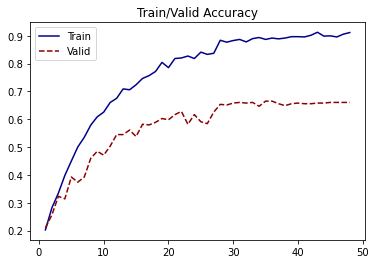

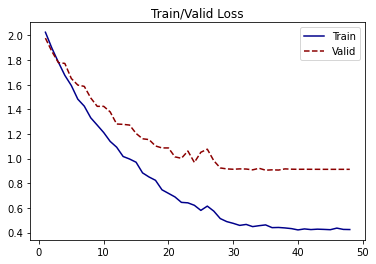

In [16]:
import matplotlib.pyplot as plt

acc=history.history["accuracy"]
val_acc=history.history["val_accuracy"]
loss=history.history["loss"]
val_loss=history.history["val_loss"]
epoch_stop = len(acc)
epochs=np.arange(1, epoch_stop+1)

plt.plot(epochs, acc, label = "Train", color = 'darkblue')
plt.plot(epochs, val_acc, label = "Valid", linestyle="--", color = 'darkred')
plt.legend()
plt.title('Train/Valid Accuracy')
plt.show()

plt.plot(epochs, loss, label = "Train", color = 'darkblue')
plt.plot(epochs, val_loss, label = "Valid", linestyle="--", color = 'darkred')
plt.legend()
plt.title('Train/Valid Loss')
plt.show()

## Evaluate model on test dataset

## Validation dataset

In [ ]:
val_preds = model.predict_classes(val_data)

mapping = {
    'CALL': 0,
    'COUG': 1,
    'DRIN': 2,
    'SCRA': 3,
    'SNEE': 4,
    'STRE': 5,
    'WAVE': 6,
    'WIPE': 7,
}
val_true = [mapping[x] for x in val_actions]

<AxesSubplot:>

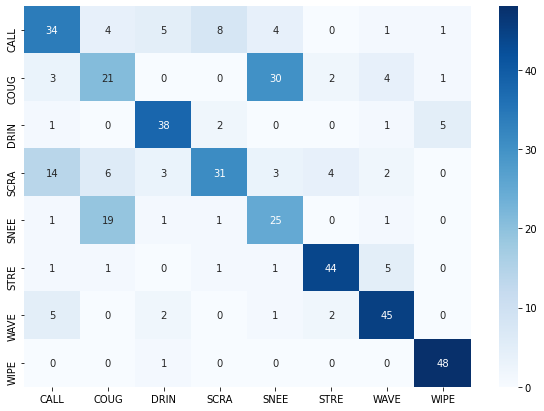

In [31]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

confusion_matrix = metrics.confusion_matrix(y_true=val_true, y_pred=val_preds)
df_cm = pd.DataFrame(confusion_matrix, index = mapping.keys(),
                  columns = mapping.keys())
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="Blues")

In [37]:
# COUG:1, SNEE:4
val_true_bin = [x in (1, 4) for x in val_true]
val_preds_bin = [x in (1, 4) for x in val_preds]

<AxesSubplot:>

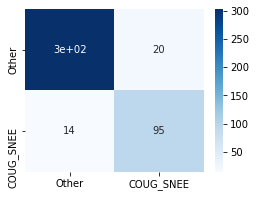

In [66]:
confusion_matrix = metrics.confusion_matrix(y_true=val_true_bin, y_pred=val_preds_bin)
df_cm = pd.DataFrame(confusion_matrix, index = ['Other', 'COUG_SNEE'],
                  columns = ['Other', 'COUG_SNEE'])
plt.figure(figsize = (4,3))
sn.heatmap(df_cm, annot=True, cmap="Blues")

In [75]:
tn, fp, fn, tp = confusion_matrix.ravel()
acc = tp / (tp+fp+fn)
acc

0.7364341085271318

## Validation dataset

In [76]:
#base_dir = '/content/drive/My Drive/cs231n/project/dataset/shaped_hrnet_data'
base_dir = '/home/ubuntu'

test_data = np.load(os.path.join(base_dir, 'test_data_pre60.npy'))
test_actions = np.load(os.path.join(base_dir, 'test_actions_pre60.npy'), allow_pickle=True)

In [81]:
# reshape data
test_data = np.moveaxis(test_data, 2, -1)

In [82]:
test_preds = model.predict_classes(test_data)

mapping = {
    'CALL': 0,
    'COUG': 1,
    'DRIN': 2,
    'SCRA': 3,
    'SNEE': 4,
    'STRE': 5,
    'WAVE': 6,
    'WIPE': 7,
}
test_true = [mapping[x] for x in test_actions]

<AxesSubplot:>

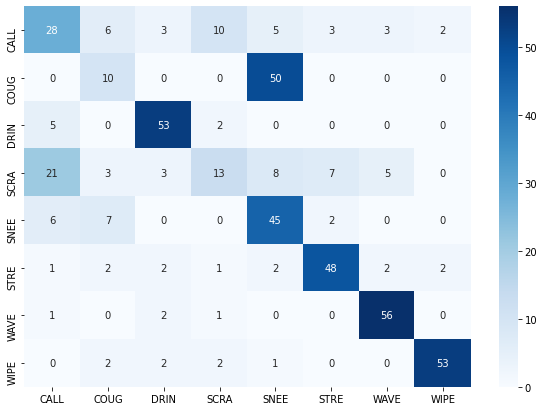

In [83]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

confusion_matrix = metrics.confusion_matrix(y_true=test_true, y_pred=test_preds)
df_cm = pd.DataFrame(confusion_matrix, index = mapping.keys(),
                  columns = mapping.keys())
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="Blues")

In [84]:
# COUG:1, SNEE:4
test_true_bin = [x in (1, 4) for x in test_true]
test_preds_bin = [x in (1, 4) for x in test_preds]

<AxesSubplot:>

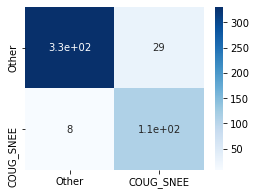

In [85]:
confusion_matrix = metrics.confusion_matrix(y_true=test_true_bin, y_pred=test_preds_bin)
df_cm = pd.DataFrame(confusion_matrix, index = ['Other', 'COUG_SNEE'],
                  columns = ['Other', 'COUG_SNEE'])
plt.figure(figsize = (4,3))
sn.heatmap(df_cm, annot=True, cmap="Blues")

In [86]:
tn, fp, fn, tp = confusion_matrix.ravel()
acc = tp / (tp+fp+fn)
acc

0.7516778523489933